In [1]:
# Import the necessary Libraries

import matplotlib.pyplot as plt
import warnings
import pandas as pd
import yfinance as yf
import cufflinks as cf
from plotly.offline import iplot, init_notebook_mode
from datetime import datetime
import backtrader as bt
import seaborn as sns
import talib
import ipywidgets as wd
from ipywidgets import interact, interact_manual

# Initialize plotly for offline mode
cf.go_offline()
init_notebook_mode(connected=True)

# Matplotlib inline for Jupyter Notebooks
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# plt.style.use('seaborn')
# plt.style.use('seaborn-colorblind') #alternative
plt.rcParams['figure.figsize'] = [8, 4.5]
plt.rcParams['figure.dpi'] = 300
warnings.simplefilter(action='ignore', category=FutureWarning)

# Technical Analysis in Python

## Creating a Candlestick Chart

### Getting ready

2. Download the adjusted prices from Yahoo Finance:

In [3]:
df_twtr = yf.download('TSLA',
                     start='2018-01-01',
                     end='2018-12-31',
                     progress=False,
                     auto_adjust=True)

### How to do it...

1. Import the libraries:

In [4]:


init_notebook_mode()

2. Create the candlestick chart using Twitter's stock prices:

In [5]:
qf = cf.QuantFig(df_twtr, title="TSLA's Stock Price",
                legend='top', name='TWTR')

3. Add volume and moving averages to the figure:

In [6]:
qf.add_volume()
qf.add_sma(periods=20, column='Close', color='red')
qf.add_ema(periods=20, color='green')

4. Display the plot:

In [7]:
qf.iplot()

## Backtesting a Strategy Based on Simple Moving Average

### How to do it...

#### Signal 

1. Import the libraries:

2. Define a class representing the trading strategy:

In [8]:
# Define the custom SMA signal class
class SmaSignal(bt.Signal):
    params = (('period', 20), )
    
    def __init__(self):
        self.lines.signal = self.data - bt.ind.SMA(period=self.p.period)

3. Download data from Yahoo Finance:

In [9]:
# Download data using yfinance
data = yf.download('TSLA', start='2018-01-01', end='2018-12-31')
data.index = pd.to_datetime(data.index)

[*********************100%%**********************]  1 of 1 completed


4. Set up the backtest:

In [10]:
# Convert data to backtrader feed format
data_feed = bt.feeds.PandasData(dataname=data)

# Initialize Cerebro engine
cerebro = bt.Cerebro(stdstats=False)

# Add the data feed
cerebro.adddata(data_feed)
cerebro.broker.setcash(1000.0)
cerebro.add_signal(bt.SIGNAL_LONG, SmaSignal)
cerebro.addobserver(bt.observers.BuySell)
cerebro.addobserver(bt.observers.Value)

5. Run the backtest:

In [11]:
# Print starting portfolio value
print(f'Starting Portfolio Value: {cerebro.broker.getvalue():.2f}')

# Run the strategy
cerebro.run()

# Print final portfolio value
print(f'Final Portfolio Value: {cerebro.broker.getvalue():.2f}')

Starting Portfolio Value: 1000.00
Final Portfolio Value: 991.13


6. Plot the results:

<IPython.core.display.Javascript object>


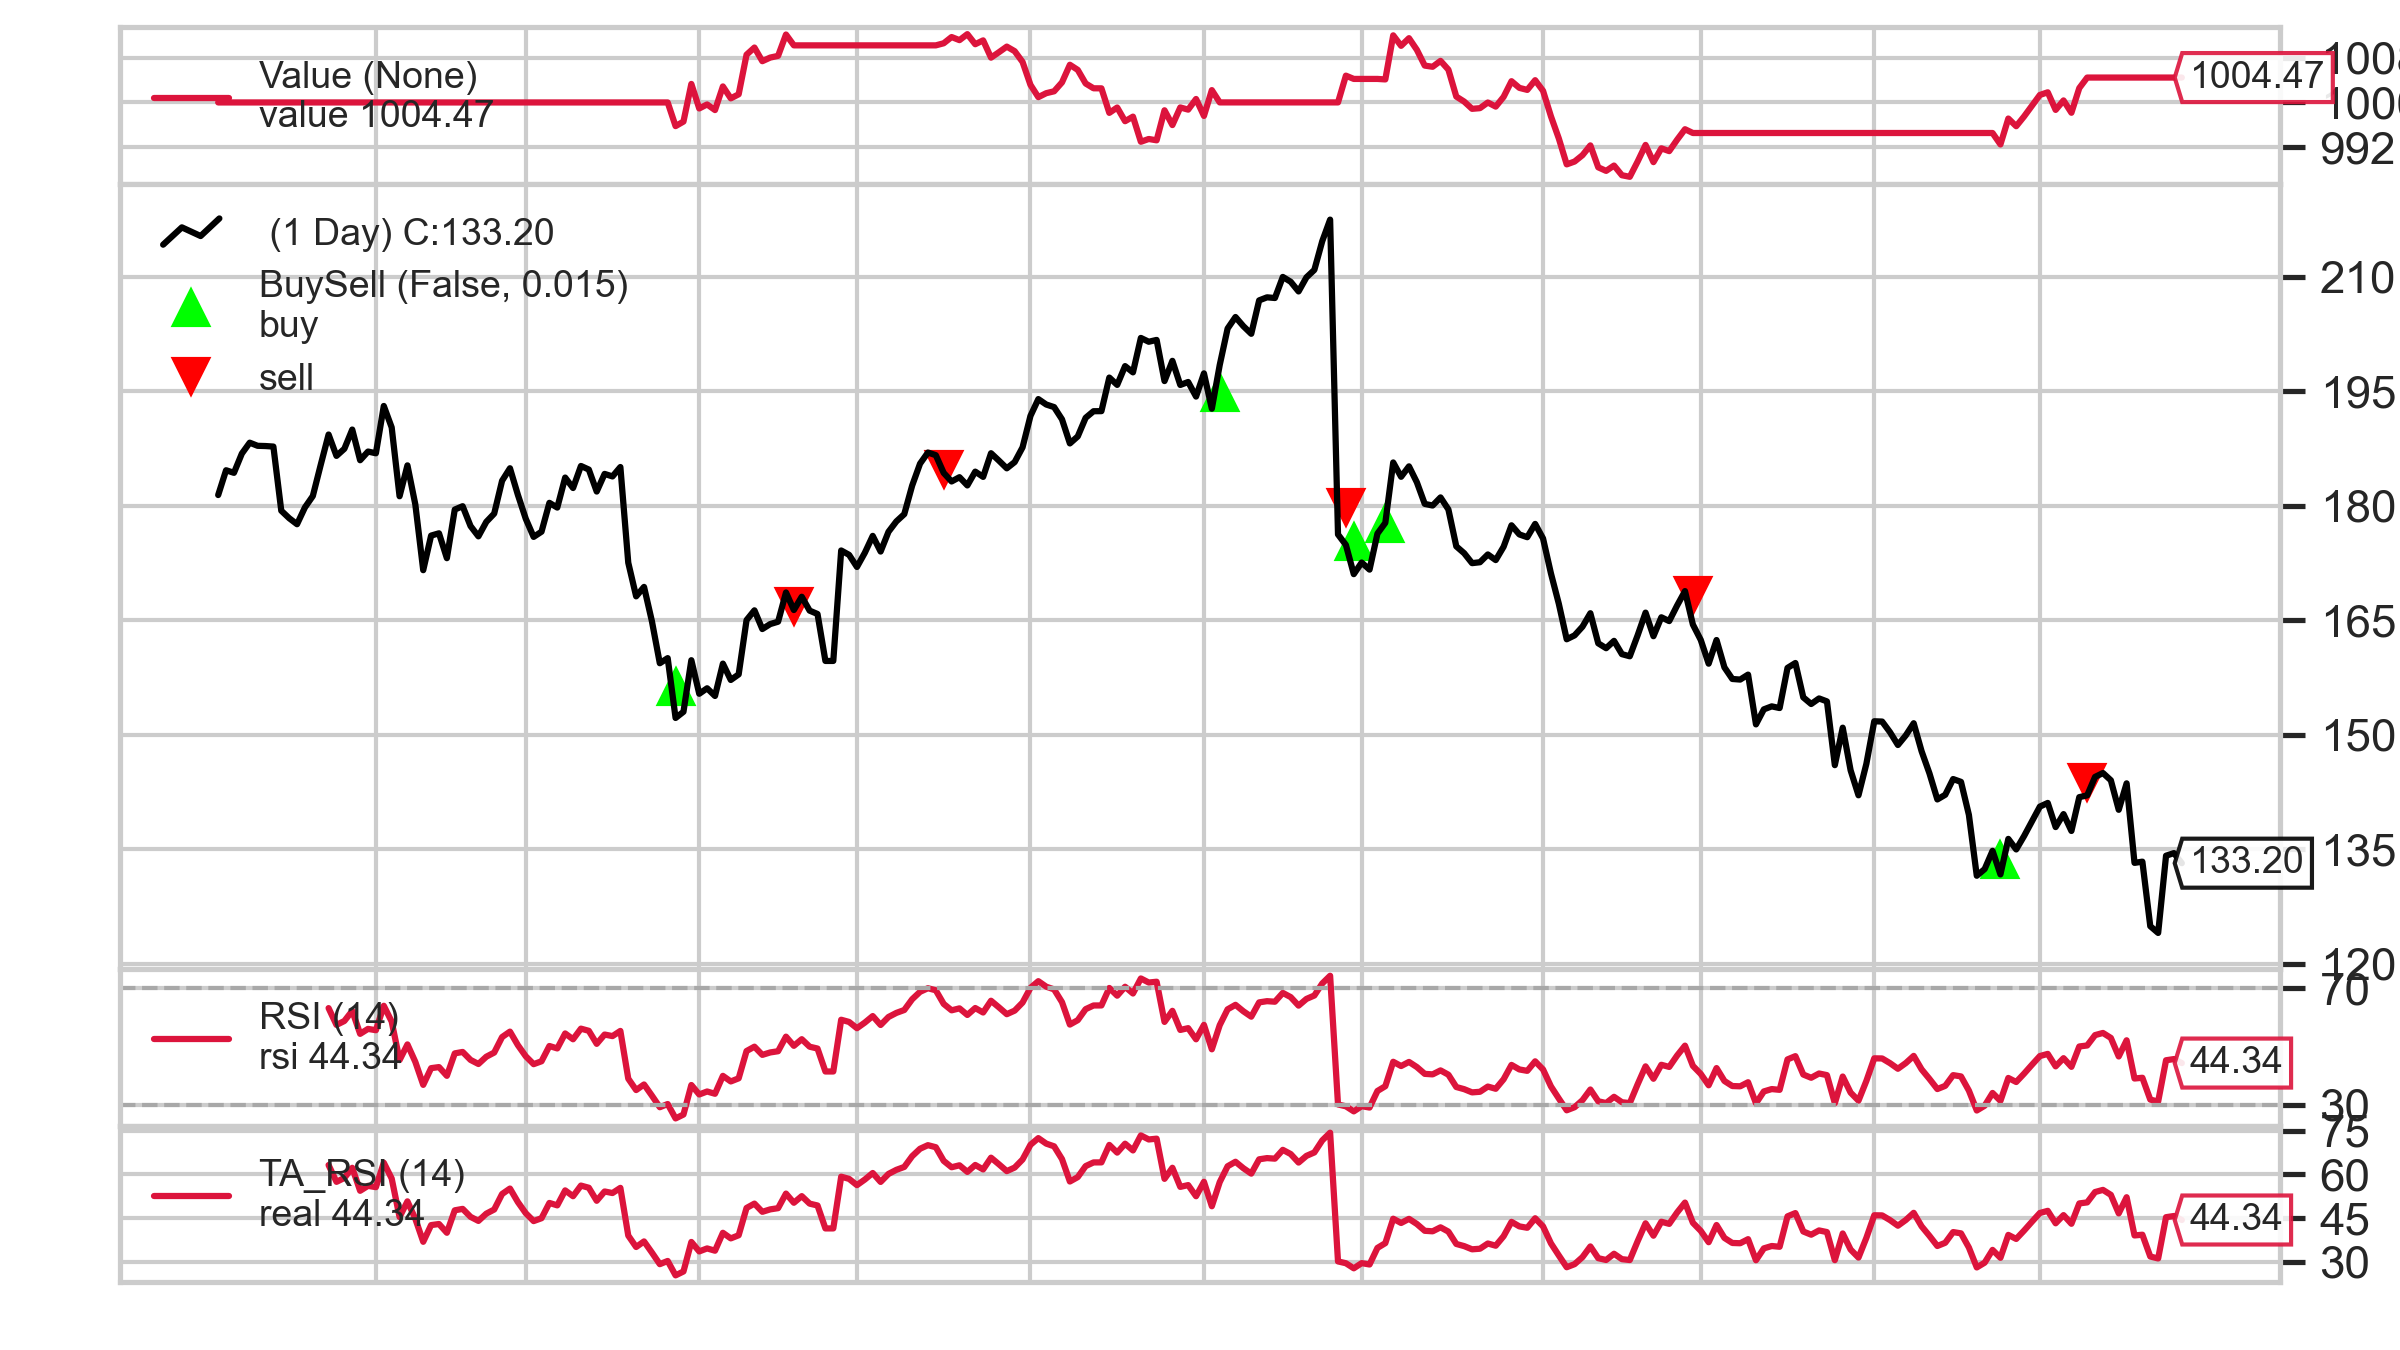

[[<Figure size 2400x1350 with 3 Axes>]]

In [12]:
cerebro.plot(iplot=True, volume=False)

#### Strategy

1. The template of the strategy looks like:

In [13]:
class SmaStrategy(bt.Strategy):
    params = (('ma_period', 20), )

    def __init__(self):
        # Keep track of close price in the series
        self.data_close = self.datas[0].close
        
        # Keep track of pending orders/buy price/buy commission
        self.order = None
        self.price = None
        self.comm = None
        
        # Add a simple moving average indicator
        self.sma = bt.indicators.SimpleMovingAverage(
            self.datas[0], period=self.params.ma_period
        )
        
    def log(self, txt):
        ''' Logging function for this strategy '''
        dt = self.datas[0].datetime.date(0).isoformat()
        print(f'{dt}, {txt}')
        
    def notify_order(self, order):
        ''' Called when an order gets accepted/complete/failed '''
        if order.status in [order.Submitted, order.Accepted]:
            # Order already submitted/accepted - no action required
            return

        # Report executed order
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f'BUY EXECUTED --- Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f}, Commission: {order.executed.comm:.2f}')
                self.price = order.executed.price
                self.comm = order.executed.comm
            else:  # Sell
                self.log(f'SELL EXECUTED --- Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f}, Commission: {order.executed.comm:.2f}')
                
        # Report failed order
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Failed')

        # Set no pending order
        self.order = None
        
    def notify_trade(self, trade):
        ''' Called when a trade is closed '''
        if not trade.isclosed:
            return
        
        self.log(f'OPERATION RESULT --- Gross: {trade.pnl:.2f}, Net: {trade.pnlcomm:.2f}')
        
    def next(self):
        ''' This method is called for each bar update '''
        # Do nothing if an order is pending
        if self.order:
            return
        
        # Check if there is already a position
        if not self.position:
            # Buy condition
            if self.data_close[0] > self.sma[0]:
                self.log(f'BUY CREATED --- Price: {self.data_close[0]:.2f}')
                self.order = self.buy()
                
        else:
            # Sell condition
            if self.data_close[0] < self.sma[0]:
                self.log(f'SELL CREATED --- Price: {self.data_close[0]:.2f}')
                self.order = self.sell()

2. Set up the backtest:

In [14]:
# Initialize Cerebro engine
cerebro = bt.Cerebro(stdstats=False)

# Add the data feed
cerebro.adddata(data_feed)
cerebro.broker.setcash(1000.0)
cerebro.addstrategy(SmaStrategy)
cerebro.addobserver(bt.observers.BuySell)
cerebro.addobserver(bt.observers.Value)

3. Run the backtest:

In [15]:
# Print starting portfolio value
print(f'Starting Portfolio Value: {cerebro.broker.getvalue():.2f}')

# Run the strategy
cerebro.run()

# Print final portfolio value
print(f'Final Portfolio Value: {cerebro.broker.getvalue():.2f}')

Starting Portfolio Value: 1000.00
2018-01-30, BUY CREATED --- Price: 23.05
2018-01-31, BUY EXECUTED --- Price: 23.17, Cost: 23.17, Commission: 0.00
2018-02-05, SELL CREATED --- Price: 22.21
2018-02-06, SELL EXECUTED --- Price: 21.68, Cost: 23.17, Commission: 0.00
2018-02-06, OPERATION RESULT --- Gross: -1.49, Net: -1.49
2018-02-07, BUY CREATED --- Price: 23.00
2018-02-08, BUY EXECUTED --- Price: 22.89, Cost: 22.89, Commission: 0.00
2018-02-08, SELL CREATED --- Price: 21.02
2018-02-09, SELL EXECUTED --- Price: 21.33, Cost: 22.89, Commission: 0.00
2018-02-09, OPERATION RESULT --- Gross: -1.56, Net: -1.56
2018-02-22, BUY CREATED --- Price: 23.08
2018-02-23, BUY EXECUTED --- Price: 23.19, Cost: 23.19, Commission: 0.00
2018-03-01, SELL CREATED --- Price: 22.06
2018-03-02, SELL EXECUTED --- Price: 21.80, Cost: 23.19, Commission: 0.00
2018-03-02, OPERATION RESULT --- Gross: -1.39, Net: -1.39
2018-03-02, BUY CREATED --- Price: 22.34
2018-03-05, BUY EXECUTED --- Price: 22.16, Cost: 22.16, Commi

Plot the results:

In [16]:
cerebro.plot(iplot=True, volume=False)

[[<Figure size 2400x1350 with 2 Axes>]]

## Calculating Bollinger Bands and testing a buy/sell strategy

1. Import the libraries

2. The template of the strategy looks like:

In [17]:
class BBand_Strategy(bt.Strategy):
    params = (('period', 20),
              ('devfactor', 2.0),)
    
    def __init__(self):
        # Keep track of close and open prices in the series
        self.data_close = self.datas[0].close
        self.data_open = self.datas[0].open
        
        # Keep track of pending orders/buy price/buy commission
        self.order = None
        self.price = None
        self.comm = None
            
        # Add Bollinger Bands indicator
        self.b_band = bt.indicators.BollingerBands(self.datas[0], 
                                                   period=self.p.period, 
                                                   devfactor=self.p.devfactor)
        # Track buy/sell signals using crossovers
        self.buy_signal = bt.indicators.CrossOver(self.datas[0], self.b_band.lines.bot)
        self.sell_signal = bt.indicators.CrossOver(self.datas[0], self.b_band.lines.top)
            
    def log(self, txt):
        ''' Logging function for this strategy '''
        dt = self.datas[0].datetime.date(0).isoformat()
        print(f'{dt}, {txt}')
        
    def notify_order(self, order):
        ''' Called when an order gets accepted/complete/failed '''
        if order.status in [order.Submitted, order.Accepted]:
            # Order already submitted/accepted - no action required
            return
        
        # Report executed order
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f'BUY EXECUTED --- Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f}, Commission: {order.executed.comm:.2f}')
                self.price = order.executed.price
                self.comm = order.executed.comm
            else:  # Sell
                self.log(f'SELL EXECUTED --- Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f}, Commission: {order.executed.comm:.2f}')
                
        # Report failed order
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Failed')

        # Set no pending order
        self.order = None
        
    def notify_trade(self, trade):
        ''' Called when a trade is closed '''
        if not trade.isclosed:
            return
        
        self.log(f'OPERATION RESULT --- Gross: {trade.pnl:.2f}, Net: {trade.pnlcomm:.2f}')
        
    def next_open(self):
        ''' This method is called at the next bar's open price '''
        # Do nothing if an order is pending
        if self.order:
            return
        
        # Check if there is no existing position
        if not self.position:
            # Buy condition
            if self.buy_signal > 0:
                # Calculate the max number of shares ('all-in')
                size = int(self.broker.getcash() / self.datas[0].open)
                # Create a buy order
                self.log(f'BUY CREATED --- Size: {size}, Cash: {self.broker.getcash():.2f}, Open: {self.data_open[0]}, Close: {self.data_close[0]}')
                self.order = self.buy(size=size)
                
        else:
            # Sell condition
            if self.sell_signal < 0:
                # Create a sell order
                self.log(f'SELL CREATED --- Size: {self.position.size}')
                self.order = self.sell(size=self.position.size)

3. Download data:

In [18]:
# Download data using yfinance
data = yf.download('MSFT', start='2018-01-01', end='2018-12-31')
data.index = pd.to_datetime(data.index)

# Convert data to backtrader feed format
data_feed = bt.feeds.PandasData(dataname=data)

[*********************100%%**********************]  1 of 1 completed


4. Set up the backtest:

In [19]:
# Initialize Cerebro engine
cerebro = bt.Cerebro(stdstats=False, cheat_on_open=True)

# Add the data feed
cerebro.adddata(data_feed)
cerebro.broker.setcash(10000.0)
cerebro.broker.setcommission(commission=0.001)
cerebro.addstrategy(BBand_Strategy)
cerebro.addobserver(bt.observers.BuySell)
cerebro.addobserver(bt.observers.Value)
cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')
cerebro.addanalyzer(bt.analyzers.TimeReturn, _name='time_return')

5. Run the backtest:

In [20]:
# Print starting portfolio value
print(f'Starting Portfolio Value: {cerebro.broker.getvalue():.2f}')

# Run the strategy
backtest_result = cerebro.run()

# Print final portfolio value
print(f'Final Portfolio Value: {cerebro.broker.getvalue():.2f}')

Starting Portfolio Value: 10000.00
2018-02-12, BUY CREATED --- Size: 112, Cash: 10000.00, Open: 88.73999786376953, Close: 89.12999725341797
2018-02-12, BUY EXECUTED --- Price: 88.74, Cost: 9938.88, Commission: 9.94
2018-04-19, SELL CREATED --- Size: 112
2018-04-19, SELL EXECUTED --- Price: 96.44, Cost: 9938.88, Commission: 10.80
2018-04-19, OPERATION RESULT --- Gross: 862.40, Net: 841.66
2018-06-29, BUY CREATED --- Size: 109, Cash: 10841.66, Open: 98.93000030517578, Close: 98.61000061035156
2018-06-29, BUY EXECUTED --- Price: 98.93, Cost: 10783.37, Commission: 10.78
2018-07-17, SELL CREATED --- Size: 109
2018-07-17, SELL EXECUTED --- Price: 104.61, Cost: 10783.37, Commission: 11.40
2018-07-17, OPERATION RESULT --- Gross: 619.12, Net: 596.93
2018-10-15, BUY CREATED --- Size: 105, Cash: 11438.59, Open: 108.91000366210938, Close: 107.5999984741211
2018-10-15, Order Failed
2018-10-26, BUY CREATED --- Size: 108, Cash: 11438.59, Open: 105.69000244140625, Close: 106.95999908447266
2018-10-26,

6. Plot the results:

In [21]:
cerebro.plot(iplot=True, volume=False)

[[<Figure size 2400x1350 with 4 Axes>]]

7. Run to investigate different returns metrics:

In [22]:
print(backtest_result[0].analyzers.returns.get_analysis())

OrderedDict([('rtot', 0.08202041312165345), ('ravg', 0.0003280816524866138), ('rnorm', 0.0861904521354339), ('rnorm100', 8.61904521354339)])


8. Create a plot of daily portfolio returns:

In [23]:
# Set seaborn style
sns.set(style='whitegrid')

# Set figure properties
plt.rcParams['figure.figsize'] = [8, 4.5]
plt.rcParams['figure.dpi'] = 300

# Ignore future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

<IPython.core.display.Javascript object>


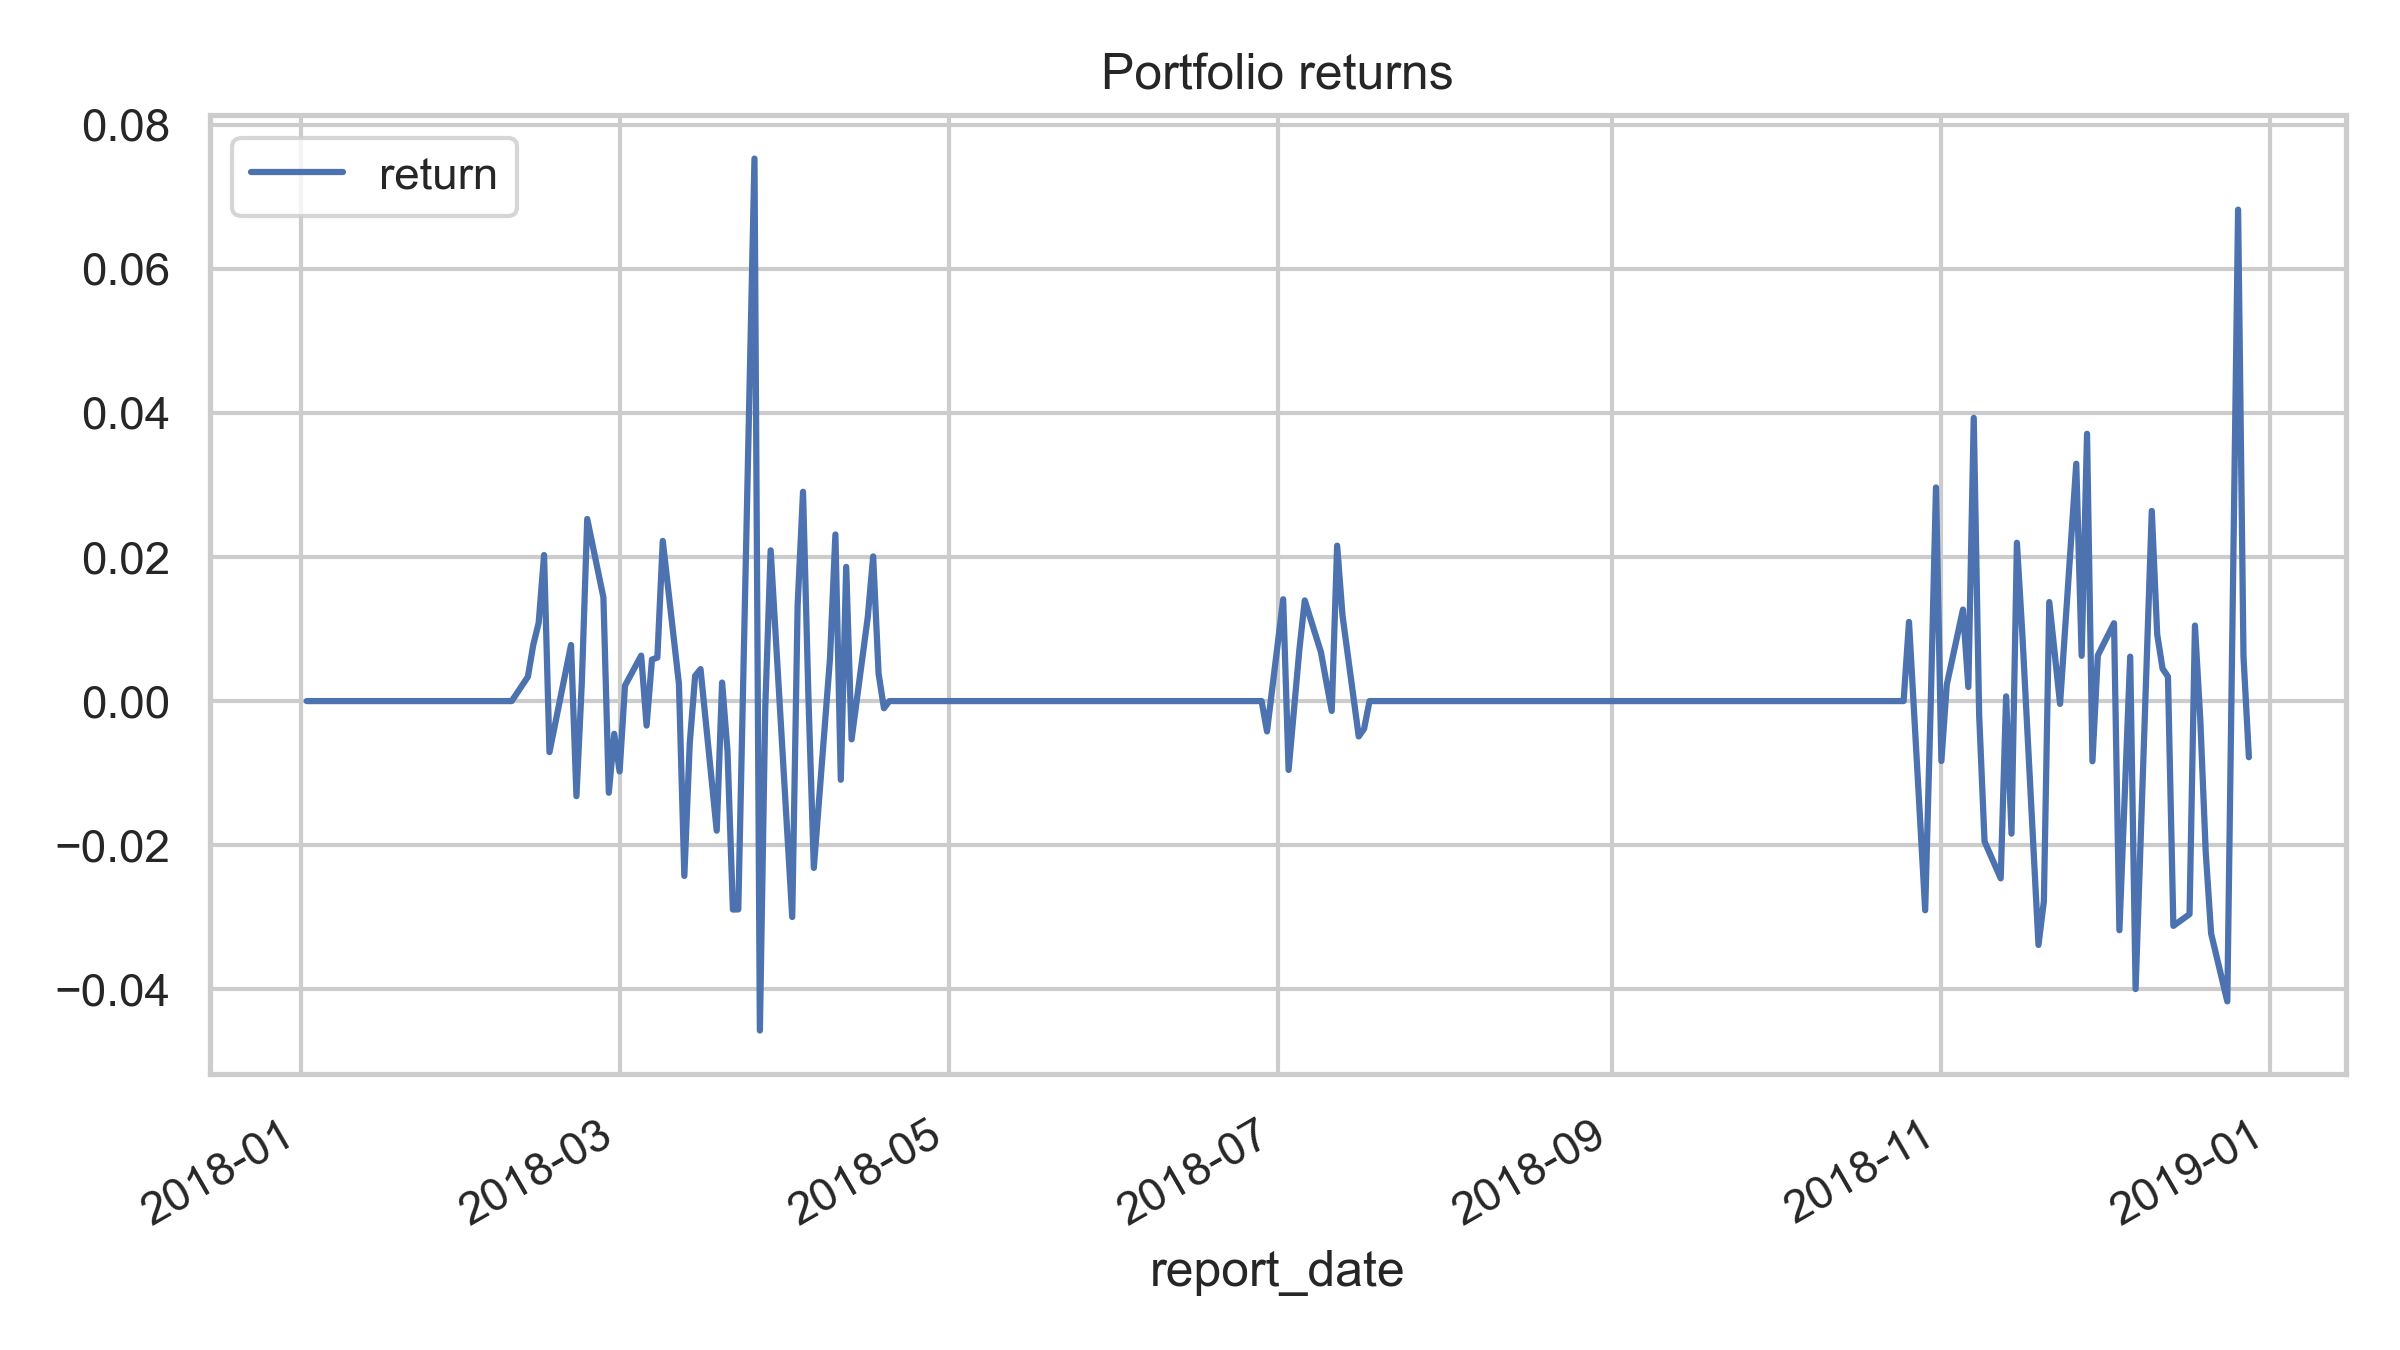

In [24]:
returns_dict = backtest_result[0].analyzers.time_return.get_analysis()
returns_df = pd.DataFrame(list(returns_dict.items()), 
                         columns = ['report_date', 'return']) \
.set_index('report_date')
returns_df.plot(title='Portfolio returns')

plt.tight_layout()
plt.show()

## Calculating the relative strength index and testing a long/short strategy

2. Define the signal strategy based on bt.SignalStrategy:

In [25]:
class RsiSignalStrategy(bt.SignalStrategy):
    params = dict(rsi_periods=14, rsi_upper=70, rsi_lower=30, rsi_mid=50)
    
    def __init__(self):
        # Add RSI indicator
        rsi = bt.indicators.RSI(period=self.p.rsi_periods,
                                upperband=self.p.rsi_upper,
                                lowerband=self.p.rsi_lower)
        
        # Add RSI from TA-lib just for reference
        bt.talib.RSI(self.data, plotname='TA_RSI')
        
        # Long condition (RSI crossing up the lower threshold)
        rsi_signal_long = bt.ind.CrossUp(rsi, self.p.rsi_lower, plot=False)
        self.signal_add(bt.SIGNAL_LONG, rsi_signal_long)
        
        # Long exit condition (RSI exceeding the midpoint)
        self.signal_add(bt.SIGNAL_LONGEXIT, -(rsi > self.p.rsi_mid))
        
        # Short condition (RSI crossing down the upper threshold)
        rsi_signal_short = -bt.ind.CrossDown(rsi, self.p.rsi_upper, plot=False)
        self.signal_add(bt.SIGNAL_SHORT, rsi_signal_short)
        
        # Short exit condition (RSI dropping below the midpoint)
        self.signal_add(bt.SIGNAL_SHORTEXIT, rsi < self.p.rsi_mid)

3. Download data:

In [26]:
# Download data using yfinance
data = yf.download('META', start='2018-01-01', end='2018-12-31')
data.index = pd.to_datetime(data.index)

# Convert data to backtrader feed format
data_feed = bt.feeds.PandasData(dataname=data)

[*********************100%%**********************]  1 of 1 completed


4. Set up and run the backtest:

In [27]:
# Initialize Cerebro engine
cerebro = bt.Cerebro(stdstats=False)

# Add the strategy and data feed
cerebro.addstrategy(RsiSignalStrategy)
cerebro.adddata(data_feed)
cerebro.broker.setcash(1000.0)
cerebro.broker.setcommission(commission=0.001)
cerebro.addobserver(bt.observers.BuySell)
cerebro.addobserver(bt.observers.Value)

In [28]:
# Run the strategy
print(f'Starting Portfolio Value: {cerebro.broker.getvalue():.2f}')

cerebro.run()

print(f'Final Portfolio Value: {cerebro.broker.getvalue():.2f}')

Starting Portfolio Value: 1000.00
Final Portfolio Value: 1004.47


5. Plot the results:

In [29]:
# Plot results using matplotlib
cerebro.plot(volume=False)

[[<Figure size 2400x1350 with 4 Axes>]]

## Building an Interactive Dashboard for Technical Analysis

1. Import the libraries:

In [30]:
init_notebook_mode()

2. Define the possible values for assets and technical indicators:

In [31]:
stocks = ['X', 'MSFT', 'GOOGL', 'META', 'TSLA', 'AAPL']
indicators = ['Bollinger Bands', 'MACD', 'RSI']

3. Define a function for creating the interactive plot:

In [32]:
def ta_dashboard(asset, indicator, start_date, end_date, 
                 bb_k=2, bb_n=20, macd_fast=12, macd_slow=26, macd_signal=9,
                 rsi_periods=14, rsi_upper=70, rsi_lower=30):
    """
    Create a technical analysis dashboard for a given asset using specified indicators.
    
    Parameters
    ----------
    asset : str
        The asset symbol to download data for (e.g., 'AAPL').
    indicator : list
        List of indicators to include in the dashboard (e.g., ['Bollinger Bands', 'MACD', 'RSI']).
    start_date : str
        The start date for historical data (e.g., '2020-01-01').
    end_date : str
        The end date for historical data (e.g., '2021-01-01').
    bb_k : int, optional
        The number of standard deviations for Bollinger Bands (default is 2).
    bb_n : int, optional
        The number of periods for Bollinger Bands (default is 20).
    macd_fast : int, optional
        The fast period for MACD (default is 12).
    macd_slow : int, optional
        The slow period for MACD (default is 26).
    macd_signal : int, optional
        The signal period for MACD (default is 9).
    rsi_periods : int, optional
        The number of periods for RSI (default is 14).
    rsi_upper : int, optional
        The upper threshold for RSI (default is 70).
    rsi_lower : int, optional
        The lower threshold for RSI (default is 30).
        
    Returns
    -------
    plotly.graph_objs._figure.Figure
        The interactive plot generated by Cufflinks.
    """
    # Download historical data for the specified asset
    df = yf.download(asset, start=start_date, end=end_date, progress=False, auto_adjust=True)
    
    # Create a QuantFig object with the downloaded data
    qf = cf.QuantFig(df, title=f'TA Dashboard - {asset}', legend='right', name=f'{asset}')
    
    # Add Bollinger Bands to the plot if specified
    if 'Bollinger Bands' in indicator: 
        qf.add_bollinger_bands(periods=bb_n, boll_std=bb_k)
    
    # Add MACD to the plot if specified
    if 'MACD' in indicator: 
        qf.add_macd(fast_period=macd_fast, slow_period=macd_slow, signal_period=macd_signal)
    
    # Add RSI to the plot if specified
    if 'RSI' in indicator: 
        qf.add_rsi(periods=rsi_periods, rsi_upper=rsi_upper, rsi_lower=rsi_lower, showbands=True)
        
    # Display the interactive plot
    return qf.iplot()

4. Define the selectors:

In [33]:
stocks_selector = wd.Dropdown(options=stocks,
                             value=stocks[0], 
                             description='Asset')

indicator_selector = wd.SelectMultiple(description='Indicator',
                                      options=indicators, 
                                      value=[indicators[0]])

start_date_selector = wd.DatePicker(description='Start Date', 
                                   value=pd.to_datetime('2018-01-01'), 
                                   continuous_update=False)

end_date_selector = wd.DatePicker(description='End Date', 
                                 value=pd.to_datetime('2018-12-31'), 
                                 continuous_update=False)

5. Define a label and group the selectors inside a container:

In [34]:
main_selector_label = wd.Label('Main parameters', 
                              layout=wd.Layout(height='45px'))

main_selector_box = wd.VBox(children=[main_selector_label,
                                     stocks_selector,
                                     indicator_selector,
                                     start_date_selector,
                                     end_date_selector])

6. Define the secondary selectors for Bollinger Bands:

In [35]:
bb_label = wd.Label('Bollinger Bands')

n_param = wd.IntSlider(value=20, min=1, max=40, step=1, 
                      description='N:', continuous_update=False)

k_param = wd.FloatSlider(value=2, min=0.5, max=4, step=0.5, 
                        description='k:', continuous_update=False)

bollinger_box = wd.VBox(children=[bb_label, n_param, k_param])

7. Define the secondary selectors for MACD:

In [36]:
macd_label = wd.Label('MACD')

macd_fast = wd.IntSlider(value=12, min=2, max=50, step=1, 
                        description='Fast avg:', 
                        continuous_update=False)

macd_slow = wd.IntSlider(value=26, min=2, max=50, step=1, 
                        description='Slow avg:', 
                        continuous_update=False)

macd_signal = wd.IntSlider(value=9, min=2, max=50, step=1, 
                          description='MACD signal:', 
                          continuous_update=False)

macd_box = wd.VBox(children=[macd_label, macd_fast, 
                            macd_slow, macd_signal])

8. Define the secondary selectors for RSI:

In [37]:
rsi_label = wd.Label('RSI')

rsi_periods = wd.IntSlider(value=14, min=2, max=50, step=1, 
                          description='RSI periods:', 
                          continuous_update=False)

rsi_upper = wd.IntSlider(value=70, min=1, max=100, step=1, 
                        description='Upper Thr:', 
                        continuous_update=False)

rsi_lower = wd.IntSlider(value=30, min=1, max=100, step=1, 
                        description='Lower Thr:', 
                        continuous_update=False)

rsi_box = wd.VBox(children=[rsi_label, rsi_periods, 
                           rsi_upper, rsi_lower])

9. Create the labels and group the selectors into containers:

In [38]:
sec_selector_label = wd.Label('Secondary parameters', 
                             layout=wd.Layout(height='45px'))
blank_label = wd.Label('', layout=wd.Layout(height='45px'))

sec_box_1 = wd.VBox([sec_selector_label, bollinger_box, macd_box])
sec_box_2 = wd.VBox([blank_label, rsi_box])

secondary_selector_box = wd.HBox([sec_box_1, sec_box_2])

10. Group the boxes and prepare the interactive output:

In [39]:
controls_dict = {'asset':stocks_selector, 
                'indicator':indicator_selector, 
                'start_date':start_date_selector, 
                'end_date':end_date_selector, 
                'bb_k':k_param, 
                'bb_n':n_param,
                'macd_fast': macd_fast, 
                'macd_slow': macd_slow, 
                'macd_signal': macd_signal,
                'rsi_periods': rsi_periods, 
                'rsi_upper': rsi_upper,
                'rsi_lower': rsi_lower}

ui = wd.HBox([main_selector_box, secondary_selector_box])
out = wd.interactive_output(ta_dashboard, controls_dict)

11. Display the dashboard:

In [40]:
display(ui, out)

Output()